# Smoothing particles

In [1]:
# Libraries ----
import sys  # type: ignore
import imageio  # type: ignore
import warnings
import numpy as np  # type: ignore
import pandas as pd  # type: ignore

sys.path.append('../modules')
import track_particles as tp  # type: ignore
import plot_tracking as plt_tp  # type: ignore
import plot_smoothing as plt_sp  # type: ignore
import plot_clustering as plt_cp  # type: ignore
import smoothing_particles as sp  # type: ignore

# Global options ----
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)

## Global variables

In [2]:
input_path = "../input_files"
output_path = "../output_files"
log_path = "../logs"
input_generation_date = "2025-02-18"

ordering = True
video_name = "2n_2m_0f_230523_1"
n_particles = int(video_name[0])
save_figures = True
x_bounds = [0, 1080]
y_bounds = [70, 1840]
x_zoom = [0, 1080]
y_zoom = [0, 1920]

## Load tracked data

In [3]:
df_tracked = pd.read_csv("{}/clustered_{}.csv".format(output_path, video_name), low_memory=False)
df_tracked.head(n_particles)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count,delta_time,velocity_x,velocity_y,velocity_orientation,mask_x,mask_y,mask_orientation
0,0,0,188.442485,504.141178,195.722135,487.933749,0.0,239.0,369.0,0.658824,222.0,513.0,0.381088,16674.0,279.701708,87.672121,0.949605,2,NaN,NaN,NaN,NaN,False,False,False
1,1,0,1214.709032,591.475676,1211.462986,583.580024,0.0,1201.0,455.0,0.576471,1179.0,481.0,-0.135810,13053.0,277.931015,76.644470,0.961224,2,NaN,NaN,NaN,NaN,False,False,False


## Swapping mixed IDs

In [4]:
omega_threshold = 20 * np.pi / 180  # Angular velocity per frame (in degrees)
velocity_threshold = 83  # Velocity per frame limited with half average size of particle
print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")
delta = 400

from importlib import reload
reload(sp)

arg_list = [
    # VIDEO 1
    [0    , 10000, velocity_threshold, omega_threshold, True],
    [10000, 20000, velocity_threshold, omega_threshold, True],
    [20000, 30000, velocity_threshold, omega_threshold, True],
    [30000, 40000, velocity_threshold, omega_threshold, True],
    [40000, 50000, velocity_threshold, omega_threshold, True],
    [50000, 60000, velocity_threshold, omega_threshold, True],
    [60000, 70000, velocity_threshold, omega_threshold, True],
    [70000, 80000, velocity_threshold, omega_threshold, True],
    [80000, 90000, velocity_threshold, omega_threshold, True],
    [90000, 100000, velocity_threshold, omega_threshold, True],
    [100000, 108000, velocity_threshold, omega_threshold, True]
]

df_final = sp.smooth_frames(
    df_tracked=df_tracked,
    arg_list=arg_list,
    order=False,
    log_path=log_path,
    log_filename="log_{}".format(video_name),
    verbose=1,
    tqdm_bar=True
)

df_final.head(8)

Thresholds:
	- Velocity: 83 
	- Angle: 20.0 



100%|███████████████████████| 11/11 [00:18<00:00,  1.65s/it]


Time: 30000 Chunks 2 Allowed time 30000 Permutation [0 1]
Time: 60000 Chunks 2 Allowed time 60000 Permutation [0 1]
Time: 90000 Chunks 2 Allowed time 90000 Permutation [0 1]


,allowed_frame,time,smooth_chunk,id,permuted_id,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,corrected_orientation,area,axis_major,axis_minor,eccentricity,id_count,delta_time,velocity_x,velocity_y,velocity_orientation,mask_x,mask_y,mask_orientation
0,True,0,chunk_00000_10000,0,0,188.442485,504.141178,195.722135,487.933749,0.0,239.000000,369.000000,0.658824,222.000000,513.000000,0.381088,0.381088,16674.0,279.701708,87.672121,0.949605,2,NaN,NaN,NaN,NaN,False,False,False
1,True,0,chunk_00000_10000,1,1,1214.709032,591.475676,1211.462986,583.580024,0.0,1201.000000,455.000000,0.576471,1179.000000,481.000000,-0.135810,-0.135810,13053.0,277.931015,76.644470,0.961224,2,NaN,NaN,NaN,NaN,False,False,False
2,True,3,chunk_00000_10000,0,0,191.089472,499.495663,198.239899,482.921423,0.0,240.000000,364.000000,0.725490,156.000000,506.000000,-0.369558,-0.369558,16832.0,282.811923,87.089584,0.951405,2,3.0,0.882329,-1.548505,0.003843,False,False,False
3,True,3,chunk_00000_10000,1,1,1213.584022,587.340537,1210.134875,578.213961,NaN,1213.584022,587.340537,NaN,1213.584022,587.340537,0.157251,0.157251,12818.0,280.706320,74.042446,0.964585,2,3.0,-0.375003,-1.378380,0.007147,False,False,False
4,True,6,chunk_00000_10000,0,0,195.320613,492.956527,202.100053,477.334559,0.0,243.000000,357.000000,0.717647,204.000000,497.000000,-0.370430,-0.370430,16378.0,281.247309,86.753744,0.951237,2,3.0,1.410380,-2.179712,-0.000291,False,False,False
5,True,6,chunk_00000_10000,1,1,1203.779279,578.183134,1199.931765,568.363370,0.0,1181.000000,449.000000,0.592157,1203.000000,511.000000,0.197405,0.197405,13542.0,275.373875,77.230379,0.959867,2,3.0,-3.268248,-3.052468,0.013385,False,False,False
6,True,9,chunk_00000_10000,0,0,195.322950,489.920040,201.559211,474.825935,0.0,247.000000,352.000000,0.650980,178.000000,502.000000,-0.364575,-0.364575,16083.0,282.189159,86.211958,0.952188,2,3.0,0.000779,-1.012162,0.001952,False,False,False
7,True,9,chunk_00000_10000,1,1,1203.059199,578.416492,1199.060429,568.536178,0.0,1181.000000,448.000000,0.639216,1210.000000,582.000000,0.198487,0.198487,13801.0,275.757203,78.184285,0.958965,2,3.0,-0.240027,0.077786,0.000361,False,False,False


In [5]:
df_final.tail(5)

,allowed_frame,time,smooth_chunk,id,permuted_id,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,corrected_orientation,area,axis_major,axis_minor,eccentricity,id_count,delta_time,velocity_x,velocity_y,velocity_orientation,mask_x,mask_y,mask_orientation
71946,True,107991,chunk_100000_108000,0,1,185.285108,216.309665,182.577864,216.002499,0.0,176.193023,193.088372,0.462745,172.693023,227.088372,1.468688,-1.468688,10398.0,177.818296,89.108347,0.865378,2,3.0,-0.175886,0.141849,0.000318,False,False,False
71949,True,107994,chunk_100000_108000,1,0,1389.751759,791.355257,1370.443829,796.334643,0.0,1460.000000,741.000000,0.592157,1435.000000,821.000000,-1.407015,-1.407015,14353.0,229.803280,88.200030,0.923413,2,3.0,0.006176,0.000149,0.000020,False,False,False
71948,True,107994,chunk_100000_108000,0,1,185.351116,216.293857,182.622680,215.985413,0.0,176.326291,193.044601,0.462745,168.326291,227.044601,1.469881,-1.469881,10413.0,177.951261,89.147611,0.865467,2,3.0,0.022003,-0.005269,0.000398,False,False,False
71951,True,107997,chunk_100000_108000,1,0,1389.715271,791.349279,1370.388662,796.320673,0.0,1460.000000,741.000000,0.592157,1429.000000,821.000000,-1.407155,-1.407155,14361.0,229.876733,88.217615,0.923433,2,3.0,-0.012163,-0.001992,-0.000046,False,False,False
71950,True,107997,chunk_100000_108000,0,1,185.337724,216.306407,182.557155,215.996102,0.0,176.376744,193.051163,0.462745,178.376744,227.051163,1.468921,-1.468921,10392.0,177.857003,89.201897,0.865136,2,3.0,-0.004464,0.004184,-0.000320,False,False,False


## Interpolation over not allowed frames

In [6]:
if ordering:
    df_full = df_final.copy().sort_values(["time", "permuted_id"])
    for id_ in range(len(df_full["permuted_id"].unique())):
        mask = df_full.loc[:,"permuted_id"]==df_full["permuted_id"].unique()[id_]
        df_full[mask]=df_full[mask].interpolate(method="linear")

In [7]:
if ordering:
    cols = [
        "id", "permuted_id", "time", "position_x", "position_y", "weighted_x", "weighted_y",
        "darkest_v", "darkest_x", "darkest_y", "lightest_v", "lightest_x", "lightest_y",
        "orientation", "corrected_orientation", "area", "axis_major", "axis_minor", "eccentricity"
    ]
    df_temp = df_full[cols]
    df_temp.to_csv("{}/interpolated_{}.csv".format(output_path, video_name), index=False)
    df_temp

Thresholds:
	- Velocity: 15.426336890079124 
	- Angle: 12.368889818600643 



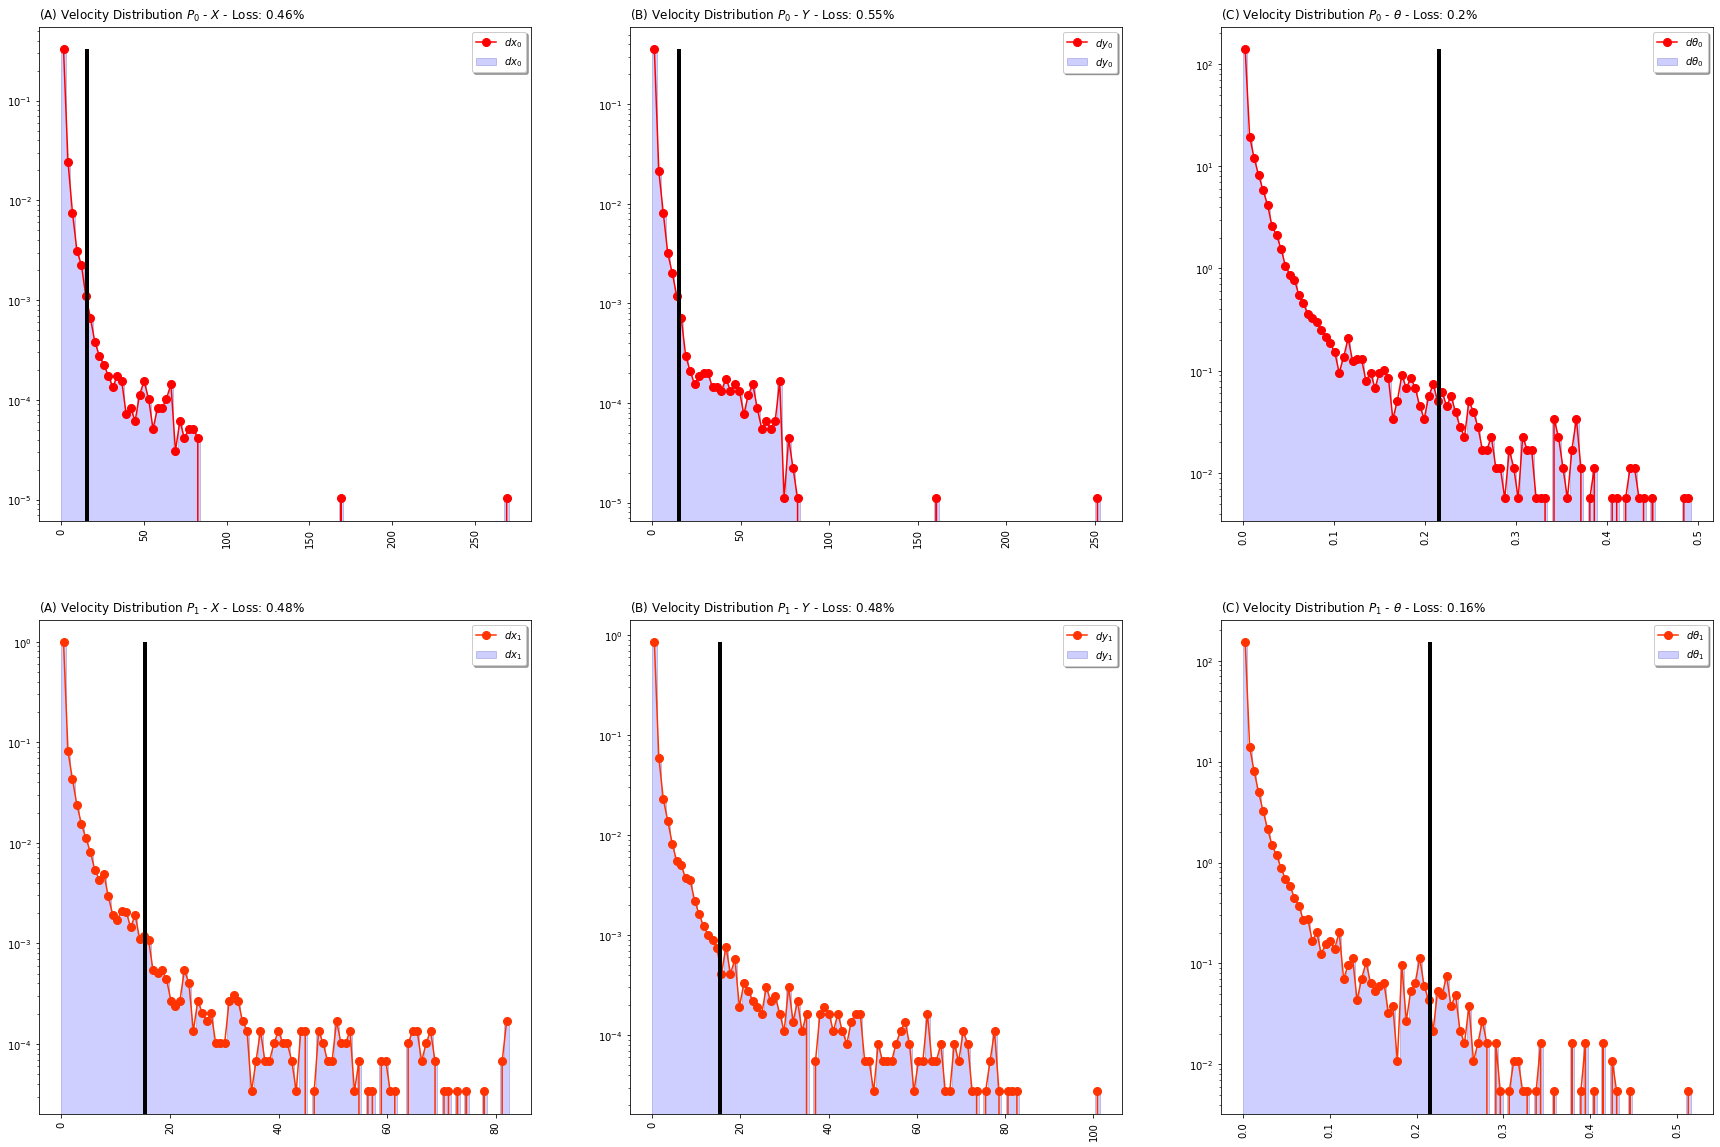

In [8]:
if ordering:
    bins = 100
    width = 10
    fancy_legend = True
    omega_threshold = df_full["velocity_orientation"].abs().quantile(0.9965) # Angular velocity per frame
    velocity_threshold = df_full["velocity_x"].abs().quantile(0.9901) # Velocity per frame limited with half average size of particle
    print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")

    df_smooth = df_full.copy()
    df_smooth["id"] = df_smooth["permuted_id"]
    df_smooth["orientation"] = df_smooth["corrected_orientation"]
    plt_cp.plot_velocities_distribution(
        df_tracked=df_smooth,
        bins=bins,
        velocity_threshold=velocity_threshold,
        omega_threshold=omega_threshold,
        width=width,
        fancy_legend=fancy_legend
    )

Original


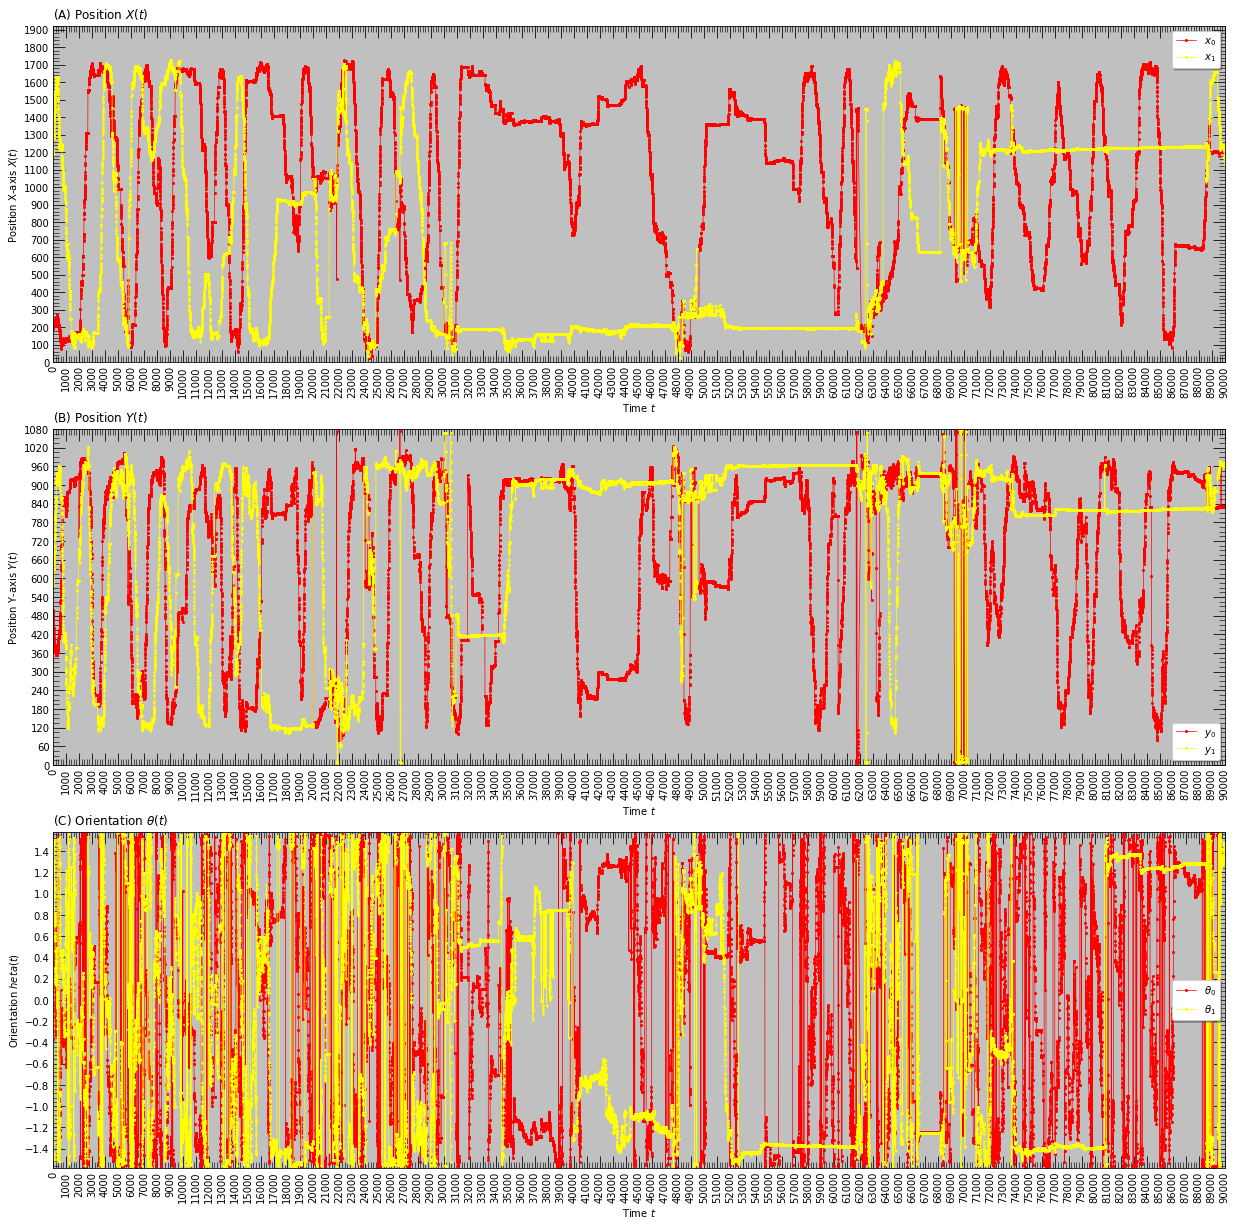

Corrected Orientation


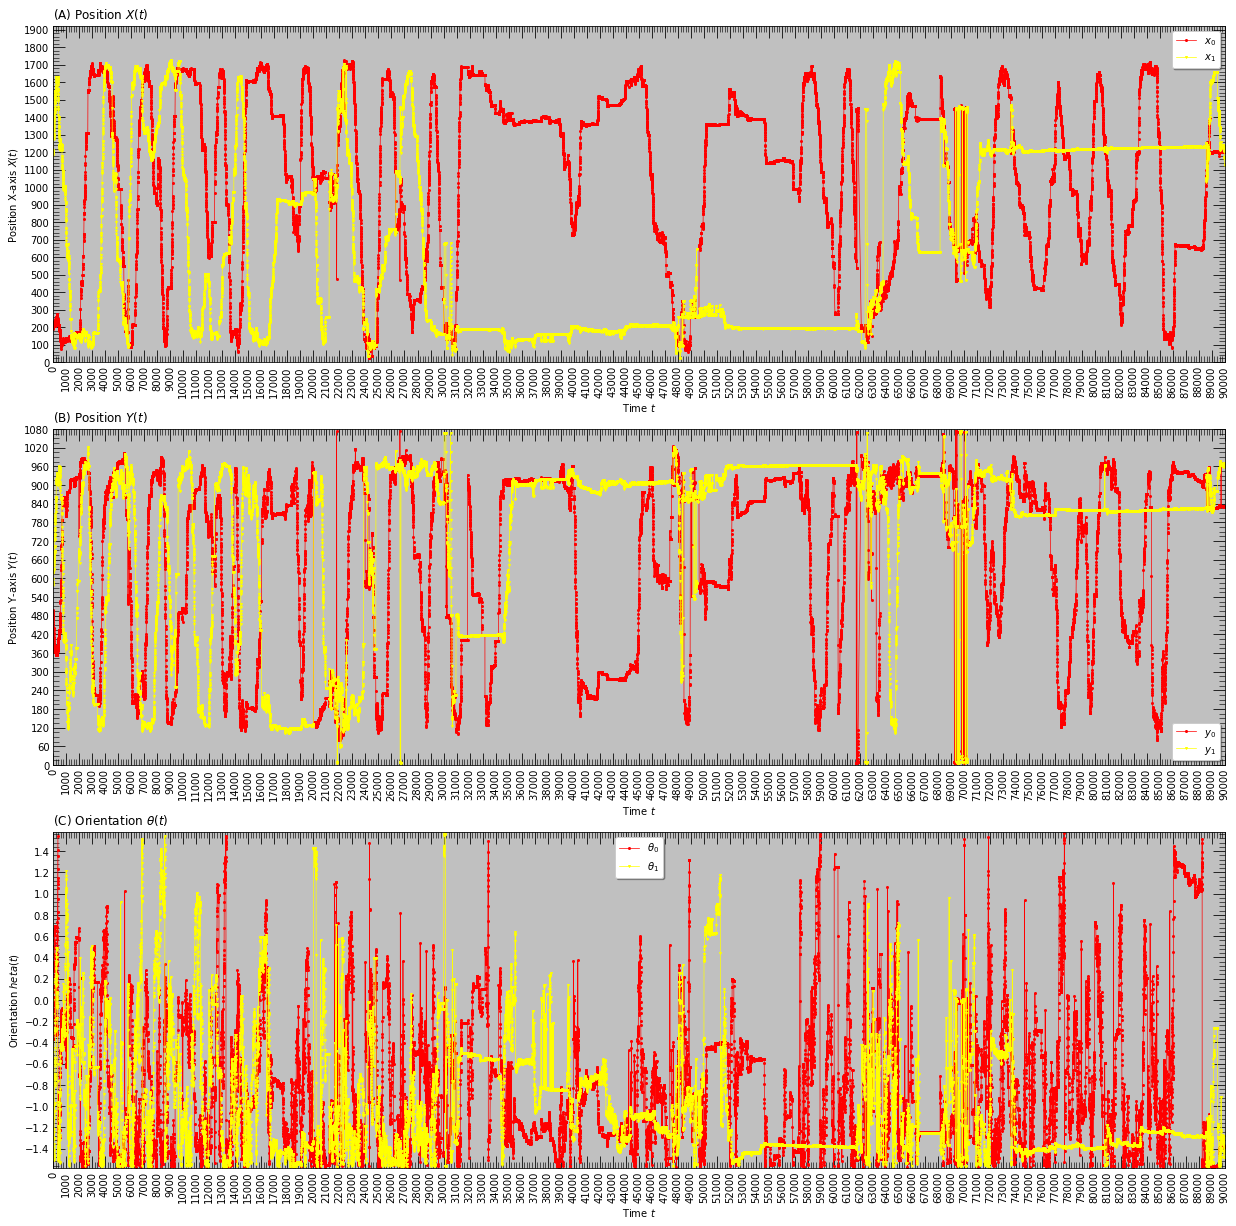

In [9]:
if ordering:
    width = 21
    n_x_breaks = 100
    n_y_breaks = 20
    t0, tf   = 0, 90000  # 22200, 24300
    t0_, tf_ = 0, 90000  # 22200, 24300
    t_bounds = [t0_, tf_]
    p_bounds = [[0, 1920], [0, 1080], [-1.58, 1.58]]
    fancy_legend = True

    print("Original")
    df_smooth = df_full.copy()
    df_smooth["id"] = df_smooth["permuted_id"]
    velocity_threshold = df_full["velocity_x"].abs().quantile(0.9701) # Velocity per frame limited with half average size of particle
    plt_sp.plot_tracking_evolution(
        df_smooth=df_smooth[((df_smooth["velocity_x"] <= velocity_threshold) & (df_smooth["velocity_y"] <= velocity_threshold))],
        width=width,
        n_x_breaks=n_x_breaks,
        n_y_breaks=n_y_breaks,
        t_bounds=[t0, tf],
        p_bounds=p_bounds,
        fancy_legend=fancy_legend
    )

    print("Corrected Orientation")
    df_smooth = df_full.copy()
    df_smooth["id"] = df_smooth["permuted_id"]
    df_smooth["orientation"] = df_smooth["corrected_orientation"]
    plt_sp.plot_tracking_evolution(
        df_smooth=df_smooth[((df_smooth["velocity_x"] <= velocity_threshold) & (df_smooth["velocity_y"] <= velocity_threshold))],
        width=width,
        n_x_breaks=n_x_breaks,
        n_y_breaks=n_y_breaks,
        t_bounds=[t0, tf],
        p_bounds=p_bounds,
        fancy_legend=fancy_legend
    )

## Setting video information

In [10]:
# # Load the video
# reader = imageio.get_reader("{}/{}.mp4".format(input_path, video_name), "ffmpeg")

# # Check the number of frames
# num_frames = reader.count_frames()
# print("Total frames: {}".format(num_frames))

# # Extract a frame to inspect the content
# time = 0
# frame = reader.get_data(time)
# print("Frames resolution: {} x {}".format(frame.shape[0], frame.shape[1]))

## Comparative of process

In [11]:
# # Original frame
# time = 209  #271  # 209  # 80
# times = [time - 1, time, time + 1]
# reinforce_boundaries = True
# remove_holes = False
# type = "local equalized"
# clip_limit = 0.05
# threshold = 0.19
# sigma = 1.5
# x_bounds = x_bounds  # [40, 1020]
# y_bounds = y_bounds  # [160, 1740]
# region_area_min = 200
# axis_major_min = 94
# eccentricity_max = 0.99


# df_tracked_frame_0 = tp.process_frame(
#     reinforce_boundaries=reinforce_boundaries,
#     remove_holes=remove_holes,
#     type=type,
#     clip_limit=clip_limit,
#     threshold=threshold,
#     sigma=sigma,
#     x_bounds=x_bounds,
#     y_bounds=y_bounds,
#     region_area_min=region_area_min,
#     axis_major_min=axis_major_min,
#     eccentricity_max=eccentricity_max,
#     tracking_list=[times[0], reader.get_data(times[0])]
# )

# df_tracked_frame_1 = tp.process_frame(
#     reinforce_boundaries=reinforce_boundaries,
#     remove_holes=remove_holes,
#     type=type,
#     clip_limit=clip_limit,
#     threshold=threshold,
#     sigma=sigma,
#     x_bounds=x_bounds,
#     y_bounds=y_bounds,
#     region_area_min=region_area_min,
#     axis_major_min=axis_major_min,
#     eccentricity_max=eccentricity_max,
#     tracking_list=[times[1], reader.get_data(times[1])]
# )

# df_tracked_frame_2 = tp.process_frame(
#     reinforce_boundaries=reinforce_boundaries,
#     remove_holes=remove_holes,
#     type=type,
#     clip_limit=clip_limit,
#     threshold=threshold,
#     sigma=sigma,
#     x_bounds=x_bounds,
#     y_bounds=y_bounds,
#     region_area_min=region_area_min,
#     axis_major_min=axis_major_min,
#     eccentricity_max=eccentricity_max,
#     tracking_list=[times[2], reader.get_data(times[2])]
# )

# df_tracked_old = pd.concat([df_tracked_frame_0, df_tracked_frame_1, df_tracked_frame_2], ignore_index=True)

# width = 10
# n_x_breaks = 20
# n_y_breaks = 20
# fancy_legend = True
# x_legend = 1.001
# y_legend = 0.891

# df_smooth = df_full.copy()
# df_smooth["id"] = df_smooth["permuted_id"]
# df_smooth["orientation"] = df_smooth["corrected_orientation"]

# fig = plt_sp.plot_all_process_frame(
#     reader=reader,
#     times=times,
#     df_tracked=df_tracked_old,
#     df_clustered=df_tracked,
#     df_smoothed=df_smooth,
#     width=width,
#     n_x_breaks=n_x_breaks,
#     n_y_breaks=n_y_breaks,
#     x_bounds=x_bounds,
#     y_bounds=y_bounds,
#     fancy_legend=fancy_legend,
#     x_legend=x_legend,
#     y_legend=y_legend
# )